# 3.0 Test Gradio Interface and Prepare Hugging Face Deployment

#### Context - Overview
- Load the best trained model (EffNetB2 or ViT)
- Run predictions on example images
- Test our Gradio app interface locally
- Validate that everything works before pushing to Hugging Face Spaces

### 6.1 Gradio overview

The overall premise of Gradio is very similar to what we've been repeating throughout the course.

What are our **inputs** and **outputs**?

And how should we get there?

Well that's what our machine learning model does.

```
inputs -> ML model -> outputs
```

In our case, for FoodVision Mini, our inputs are images of food, our ML model is EffNetB2 and our outputs are classes of food (pizza, steak or sushi).

```
images of food -> EffNetB2 -> outputs
```

Though the concepts of inputs and outputs can be bridged to almost any other kind of ML problem.

Your inputs and outputs might be any combination of the following:
* Images
* Text
* Video
* Tabular data
* Audio
* Numbers
* & more

And the ML model you build will depend on your inputs and outputs.

Gradio emulates this paradigm by creating an interface ([`gradio.Interface()`](https://gradio.app/docs/#interface-header)) from inputs to outputs.

```
gradio.Interface(fn, inputs, outputs)
```

Where, `fn` is a Python function to map the `inputs` to the `outputs`.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/09-gradio-workflow.png" alt="gradio workflow of inputs flowing into some kind of model or function and then producing outputs" width=900/>

*Gradio provides a very helpful `Interface` class to easily create an inputs -> model/function -> outputs workflow where the inputs and outputs could be almost anything you want. For example, you might input Tweets (text) to see if they're about machine learning or not or [input a text prompt to generate images](https://huggingface.co/blog/stable_diffusion).*

> **Note:** Gradio has a vast number of possible `inputs` and `outputs` options known as "Components" from images to text to numbers to audio to videos and more. You can see all of these in the [Gradio Components documentation](https://gradio.app/docs/#components).

## 0. Getting Setup

In [1]:
import torch
import random
import gradio as gr
import shutil

from PIL import Image
from typing import Tuple, Dict
from pathlib import Path
from timeit import default_timer as timer

/Users/rahulsaini/Documents/Repositories/foodvision-mini/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys

# Add project root to the system path
project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [3]:
from src.modeling import models

In [4]:
device = "cpu"

In [5]:
data_20_percent_path = Path("../data/pizza_steak_sushi_20_percent")

# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

## 1. Import the best model and load

In [6]:
MODEL_PATH = Path("../models/effnetb2.pth")

# Class labels (order must match training)
class_names = ["pizza", "steak", "sushi"]

# Define transforms
effnetb2, effnetb2_transforms = models.create_effnetb2_model(
    num_classes=len(class_names),
)

# Load the model
effnetb2.load_state_dict(
  torch.load(f=MODEL_PATH,map_location=torch.device("cpu"))
)

<All keys matched successfully>

## 2. Creating predict function which can be used by Gardio

In [7]:
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken."""
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {
        class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))
    }

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

> Create the above function in `src/modeling/predict.py`

## 3 Creating a list of example images

In [8]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")


[INFO] Predicting on image at path: ../data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg

Prediction label and probability dictionary: 
{'pizza': 0.1528167426586151, 'steak': 0.06163341552019119, 'sushi': 0.7855497598648071}
Prediction time: 0.19644 seconds


In [12]:
example_paths = random.sample(test_data_paths, k=3)

# Create the Gradio example list
example_list = [[str(p)] for p in example_paths]

# Destination path
examples_folder = Path("../examples")
examples_folder.mkdir(parents=True, exist_ok=True)

for example_path in example_paths:
    destination = examples_folder / example_path.name
    print(f"[INFO] Copying {example_path} to {destination}")
    shutil.copy2(src=example_path, dst=destination)

[INFO] Copying ../data/pizza_steak_sushi_20_percent/test/sushi/3227791.jpg to ../examples/3227791.jpg
[INFO] Copying ../data/pizza_steak_sushi_20_percent/test/pizza/3770514.jpg to ../examples/3770514.jpg
[INFO] Copying ../data/pizza_steak_sushi_20_percent/test/sushi/167716.jpg to ../examples/167716.jpg


## 4 Building a Gradio interface

In [20]:
# Create title, description and article strings
APP_TITLE = "FoodVision Mini 🍕🥩🍣"
APP_DESCRIPTION = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
APP_ARTICLE = "[Portfolio](https://www.rahulsaini.click/)"

In [24]:
import os

example_list = [["../examples/" + example] for example in os.listdir(examples_folder)]
example_list

[['../examples/3227791.jpg'],
 ['../examples/3770514.jpg'],
 ['../examples/167716.jpg']]

In [ ]:
# Create the Gradio demo
with gr.Blocks(
    css=".gradio-container { max-width: 900px !important; margin: auto; }"
) as demo:
    gr.Markdown(f"# {APP_TITLE}")
    gr.Markdown(f"### {APP_DESCRIPTION}")

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="pil", label="Upload Food Image")
            predict_btn = gr.Button("🔍 Predict")
            gr.Examples(
                examples=example_list,
                inputs=image_input,
                label="Try an example",
                examples_per_page=6,
            )
        with gr.Column(scale=1):
            label_output = gr.Label(label="Top Predictions", num_top_classes=3)
            time_output = gr.Number(label="Prediction Time (s)")

    predict_btn.click(
        fn=lambda img: predict(img),
        inputs=image_input,
        outputs=[label_output, time_output],
    )

    gr.Markdown(APP_ARTICLE)

# Launch the demo!
# demo.launch(
#     debug=False,  # print errors locally?
# )  # generate a publically shareable URL?


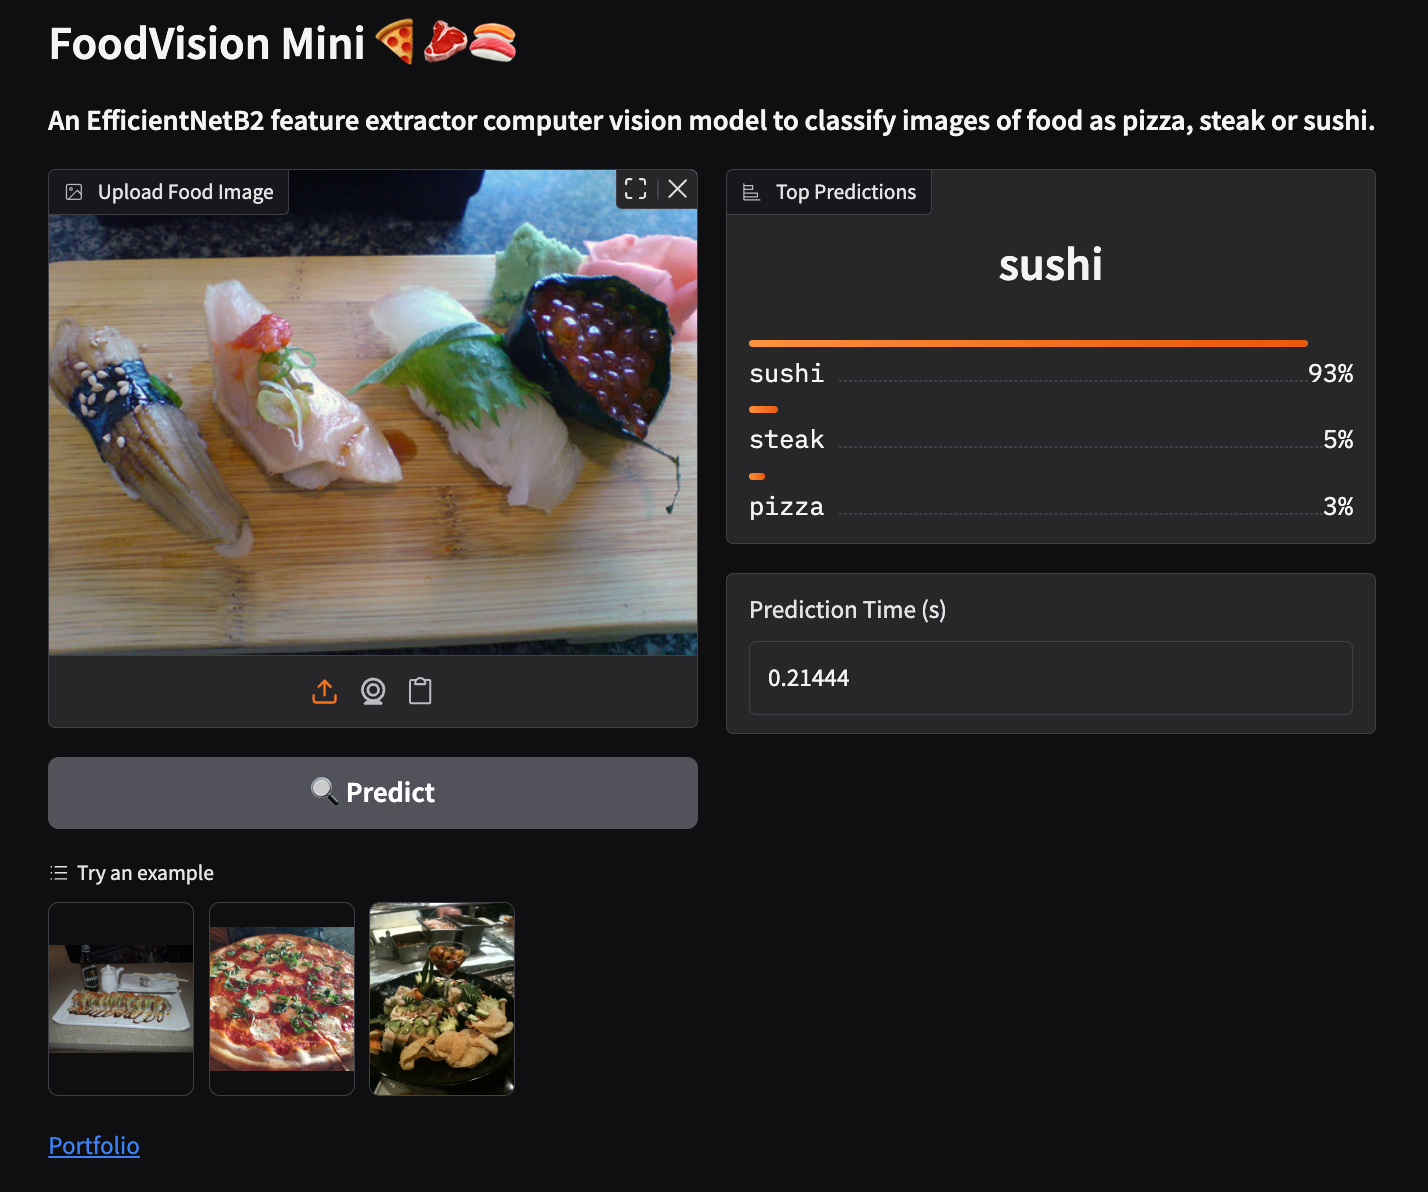

## 5. Turning our FoodVision Mini Gradio Demo into a deployable app

### 5.1 What is Hugging Face Spaces?

Hugging Face Spaces is a resource that allows you to host and share machine learning apps.

Building a demo is one of the best ways to showcase and test what you've done.

And Spaces allows you to do just that.

You can think of Hugging Face as the GitHub of machine learning.

Below code in `app.py`

In [ ]:
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from src.modeling import models, predict
from timeit import default_timer as timer
from typing import Tuple, Dict

MODEL_PATH = "../models/effnetb2.pth"
# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = models.create_effnetb2_model(
    num_classes=len(class_names), 
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f=MODEL_PATH,
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "[Portfolio](https://www.rahulsaini.click/)."

# Destination path
examples_folder = Path("../examples")
examples_folder.mkdir(parents=True, exist_ok=True)

# Create examples list from "examples/" directory
example_list = [["../examples/" + example] for example in os.listdir(examples_folder)]
example_list

# Create the Gradio demo
with gr.Blocks(
    css=".gradio-container { max-width: 900px !important; margin: auto; }"
) as demo:
    gr.Markdown(f"# {APP_TITLE}")
    gr.Markdown(f"### {APP_DESCRIPTION}")

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(type="pil", label="Upload Food Image")
            predict_btn = gr.Button("🔍 Predict")
            gr.Examples(
                examples=example_list,
                inputs=image_input,
                label="Try an example",
                examples_per_page=6,
            )
        with gr.Column(scale=1):
            label_output = gr.Label(label="Top Predictions", num_top_classes=3)
            time_output = gr.Number(label="Prediction Time (s)")

    predict_btn.click(
        fn=lambda img: predict(img),
        inputs=image_input,
        outputs=[label_output, time_output],
    )

    gr.Markdown(APP_ARTICLE)

# Launch the demo!
demo.launch()